# Frequently Used Functions in Paddle Quantum

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

In this file, we list some frequently used functions in Paddle Quantum.

You can see other functions in [API](https://qml.baidu.com/api/introduction.html)

Here we will also use preparing a pure state as an example to see how to use Paddle Quantum to realize quantum neural network algorithms.

## 1. Import Mudules 

In [1]:
# 1.1 Import numpy and paddle
import numpy as np
import paddle

# 1.2 Create quantum circuit
from paddle_quantum.circuit import UAnsatz 

# 1.3 Create quantum state - in np.ndarray form
from paddle_quantum.state import vec, vec_random  # As vector
from paddle_quantum.state import density_op, density_op_random, completely_mixed_computational  # As matrix

# 1.4 Create Matrix - in np.ndarray form
from scipy.stats import unitary_group  # Random U matrix
from paddle_quantum.utils import pauli_str_to_matrix  # Pauli matrices for n qubits

# 1.5 Matrix calculation with paddle.Tensor
from paddle import matmul, trace  # Calculate the inner product and trace
from paddle_quantum.utils import dagger  # Get dagger of a paddle.Tensor (note: for numpy.ndarray, you can use “.conj().T” to do dagger)

# 1.6 Plot figure
import matplotlib.pyplot as plt

## 2. Often Used Parameters

In [2]:
# 2.1 Parameters for quantum circuit

N = 3  # Qubits number in Quantum circuit
DEPTH = 2  # Depth of the quantum circuit (Layers number)

In [3]:
# 2.2 Parameters in the iteration 

ITR = 200  # Iteration number 
LR = 0.2   # Learning rate 
SEED = 1   # Random seed 
paddle.seed(SEED)     # seed for paddle
np.random.seed(SEED)  # seed for numpy

## 3. Numpy Matrix

In [4]:
# 3.1 Random unitary gate
V = unitary_group.rvs(2)  # Random 2*2 V

In [5]:
# 3.2 Diagonal matrix
D = np.diag([0.2, 0.8])

In [6]:
# 3.3 Transpose complex conjugate
V_dagger = V.conj().T

In [7]:
# 3.4 Matrix multiplication: @
H = (V @ D @ V_dagger)

In [8]:
# 3.5 Trace
H.trace()

(0.9999999999999998-8.239936510889834e-18j)

In [9]:
# 3.6 Eigenvalues
np.linalg.eigh(H)[0]

array([0.2, 0.8])

In [10]:
# 3.7 Tensor product: A \otimes B
A = np.eye(2)
B = H
T = np.kron(A, B)

- Note: in Paddle Quantum, you can use string to create matrix for Pauli matices with $n$ qubit.

In [11]:
# An example: 0.4*I⊗Z+0.4*Z⊗I+0.2*X⊗X
# In the string form: 0.4*kron(I, Z) + 0.4*kron(Z, I) + 0.2*kron(X, X)
H_info = [[0.4, 'z0'], [0.4, 'z1'], [0.2, 'x0,x1']]
H_matrix = pauli_str_to_matrix(H_info, 3)  # pauli matices with 3 qubits

## 4. Quantum States

In [12]:
# 4.1 Get pure states (a row vector in np.ndarray form)

initial_state_pure1 = vec(0, N)      # Get |00…0>, 2**N dimension row vector
initial_state_pure2 = vec_random(N)  # Get random pure state, row vector

In [13]:
# 4.2 Get mixed states (in np.ndarray form)

initial_state_mixed1 = density_op(N)  # Get |00…0><00…0|
# Get a random density matrix, can decide real or complex and its rank (rank = 1 means pure) 
initial_state_mixed2 = density_op_random(N, real_or_complex=2, rank=4)
initial_state_mixed3 = completely_mixed_computational(N)  # Get a maximally mixed state 

## 5. Quantum Circuit

In [14]:
# 5.1 Create an N qubits quantum circuit
cir = UAnsatz(N)

In [15]:
# 5.2 Add gates to the circuit - see Section 7
# An example: add a CNOT gate to the first two qubits:
cir.cnot([0, 1])

In [16]:
# 5.3 The output state of the circuit
# The output state of the circuit as a vector in paddle.Tensor form.
# Note: the shape of the output here is not a vector. It can be changed to a column vector 
    # via function "paddle.reshape(final_state, [2**N, 1]) —— it will be made better in the next version

# Initial state is |00...0>
final_state = cir.run_state_vector()
# Initial state is not |00...0>
initial_state_pure = paddle.to_tensor(initial_state_pure2)
final_state_pure = cir.run_state_vector(initial_state_pure)
# Change to np.array form
final_state_pure_np = cir.run_state_vector().reshape([2**N, 1]).numpy()

In [17]:
# Initial state is |00…0><00…0|
cir.run_density_matrix()
# Initial state is not |00...0><00...0|
initial_state_mixed = paddle.to_tensor(initial_state_mixed2)
final_state_mixed = cir.run_density_matrix(initial_state_mixed)
# Change to np.ndarray form
final_state_mixed_np = cir.run_density_matrix().numpy()

In [18]:
# 5.4 The unitary matrix of the circuit (in paddle.Tensor form)
cir.U
# Change to np.ndarray form
cir.U.numpy()
# Only keep the real part:
cir.U.real()
cir.U.numpy().real

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.]])

In [19]:
# 5.5 Print the circuit
print(cir)

--*--
  |  
--x--
     
-----
     


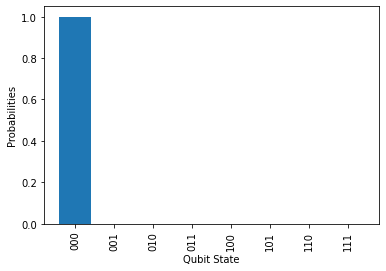

In [20]:
# 5.6 Measure outcome
res = cir.measure(shots=0, plot=True)

## 6. Angles in Quantum Gate
&emsp;Note: 
- For qubits unitary gate, they can always be characterized by a rotation axis and a rotation angle. 
- The rotation axis in Paddle Quantum is always chosen to be $x,y,z$-axis.
- The rotation angle will be the variable in QNN tasks, and **they should be given in paddle.Tensor form**.

In [21]:
# 6.1 A Single Angle

phi, theta, omega = 2 * np.pi * np.random.uniform(size=3)  # Generate a random angle
# change to paddle.Tensor
phi = paddle.to_tensor(phi, dtype='float64')

In [22]:
# 6.2 Angles in Arrays
# 1D arrays

theta = np.array([np.pi, 2 ,3, 5])  # 4 angles are different
theta = np.full([4], np.pi)  # 4 angles all equal to pi
# change to be paddle.Tensor
theta = paddle.to_tensor(theta)

In [23]:
# Multidimensional Arrays

theta = np.random.randn(DEPTH, N, 3)  # A 3D np.ndarray

For a frequently used quantum circuit: cir.complex_entangled_layer(theta, DEPTH), see 
[here](https://qml.baidu.com/quick-start/quantum-neural-network.html), the shape of theta should be(DEPTH, N, OTHER=3)

## 7. Add Quantum Gates to the Circuit

In [24]:
# 7.1 Single qubit gates 
# Note: angles should be in paddle.Tensor form.
# Subscript is the rotating axis, the first parameter is the rotating angle, the second is which qubit it acts

cir.rz(theta[0], 0)

In [25]:
# # 7.2 Two-qubit gate

cir.cnot([0, 1])

In [26]:
# 7.3 Some frequently used gates

# Add Hadamard gates to each qubit
cir.superposition_layer()
# Add a Ry(pi/4) rotation to each qubit
cir.weak_superposition_layer()

General rotation gate in Euler representation, and the corresponding circuit click [here](https://qml.baidu.com/quick-start/quantum-neural-network.html)

## 8. VQA basic structure (1) -- Create your own quantum circuit as a function
- step 1: Create an N qubit circuit;
- step 2: Add gates to each layer

In [27]:
def circuit(N, DEPTH, theta):
    """
    Input data:
         N,         qubits number
         DEPTH,     layers number
         theta,     [N, DEPTH, 2], 3D matrix in paddle.Tensor form
    Return:
         cir,       the final circuit
    """
    # step 1: Create an N qubit circuit
    cir = UAnsatz(N)
    # step 2: Add gates to each layer
    for dep in range(DEPTH):
        for n in range(N):
            cir.rx(theta[n][dep][0], n)  # add an Rx gate to the n-th qubit
            cir.rz(theta[n][dep][1], n)  # add an Rz gate to the n-th qubit
        for n in range(N - 1):
            cir.cnot([n, n + 1])  # add CNOT gate to every neighbor pair

    return cir

In [28]:
# Here is the printed final circuit for (N=3, DEPTH=2, theta is randomly generated):
theta = paddle.to_tensor(np.random.randn(N, DEPTH, 2))
theta = paddle.to_tensor(theta)
cir = circuit(N, DEPTH, theta)
print(cir)

--Rx(0.069)----Rz(0.473)----*----Rx(-0.65)----Rz(-0.77)-----------------*-------
                            |                                           |       
--Rx(-0.77)----Rz(0.623)----x--------*--------Rx(0.428)----Rz(0.074)----x----*--
                                     |                                       |  
--Rx(-0.45)----Rz(0.604)-------------x--------Rx(2.385)----Rz(-0.12)---------x--
                                                                                


## 9. VQA basic structure (2) -- forward part, calculate the loss function
- QNN optimization can be done with a Python Iterator, here is an example for preparing quantum state;
- In forward part, all variables should be always in paddle.Tensor form.

In [29]:
class StatePrepNet(paddle.nn.Layer):
    # Step 1: Give the initial input: def __init__(…)
    # Here you need to give the parameters for creating your quantum circuit and loss
    def __init__(self, N, DEPTH, psi, dtype='float64'):
        # N, DEPTH: circuit parameter
        # psi: target output pure state, np.row_vector form
        super(StatePrepNet, self).__init__()
        self.N = N
        self.DEPTH = DEPTH
        # The initial circuit parameter theta is generated randomly
        self.theta = self.create_parameter(shape=[self.N, self.DEPTH, 2],
              default_initializer=paddle.nn.initializer.Uniform(low=0., high=2 * np.pi), 
              dtype=dtype, is_bias=False)
        # Target output state, used for loss function
        self.psi = paddle.to_tensor(psi)
    # Step 2: Calculate the loss function: L = - <psi_out | psi><psi | psi_out>
    # note: here we want to minimize the loss function, so we use “-Fidelity”
    def forward(self):
        # Create the quantum circuit
        cir = circuit(self.N, self.DEPTH, self.theta)
        # Get the final state
        psi_out = cir.run_state_vector()
        psi_out = paddle.reshape(psi_out, [2 ** self.N, 1])  # reshape to ket
        # Calculate the loss function: L = - <psi_out | psi><psi | psi_out>
        inner = matmul(self.psi, psi_out)
        loss = - paddle.real(matmul(inner, dagger(inner)))[0]  # change to shape tensor([1])

        return loss, cir

## 10. VQA basic structure (3) -- backward part, optimize over iteration
- Here we still use preparing a 3-qubit pure state $|01\rangle\otimes|+\rangle$ as an example, and the circuit we use is given in section 8.
- Usually we use Adam as the optimizer.

In [30]:
N = 3      # Qubits number in Quantum circuit
DEPTH = 2  # Depth of the quantum circuit (Layers number)
ITR = 115  # Iteration number 
LR = 0.2   # Learning rate 

In [31]:
# target output state, np.ndarray row vector
psi_target = np.kron(np.kron(np.array([[1,0]]), np.array([[0,1]])), np.array([[1/np.sqrt(2), 1/np.sqrt(2)]]))  # <01+|

In [32]:
# 10.1 Record the iteration
loss_list = []
parameter_list = []

In [33]:
# 10.2 Use Iterator defined in section 9
# (N=3, DEPTH=2, ITR=110, LR=0.2)
myLayer = StatePrepNet(N, DEPTH, psi_target)

In [34]:
# 10.3 Choose the optimizer
# Usually we use Adam.
opt = paddle.optimizer.Adam(learning_rate = LR, parameters = myLayer.parameters())    

In [35]:
# 10.4 Optimize during iteration
for itr in range(ITR):
    # Use forward part to calculate the loss function
    loss = myLayer()[0]
    # Backward optimize via Gradient descent algorithm
    loss.backward()
    opt.minimize(loss)
    opt.clear_grad()
    # Record the learning curve
    loss_list.append(loss.numpy()[0])
    parameter_list.append(myLayer.parameters()[0].numpy())
    if itr % 10 == 0:
        print('iter:', itr, '  loss: %.4f' % loss.numpy())

iter: 0   loss: -0.0176
iter: 10   loss: -0.8356
iter: 20   loss: -0.9503
iter: 30   loss: -0.9837
iter: 40   loss: -0.9971
iter: 50   loss: -0.9974
iter: 60   loss: -0.9995
iter: 70   loss: -0.9999
iter: 80   loss: -0.9999
iter: 90   loss: -1.0000
iter: 100   loss: -1.0000
iter: 110   loss: -1.0000


In [36]:
# 10.5 Print the output

print('The minimum of the loss function: ', loss_list[-1])
# The parameters after optimization
theta_opt = parameter_list[-1]  # Get self.theta
print("Parameters after optimizationL theta:\n", theta_opt)
# Draw the circuit picture and the output state
# Get theta
theta_final = parameter_list[-1]
theta_final = paddle.to_tensor(theta_final)
# Print the circuit
cir_final = circuit(N, DEPTH, theta_final)
print(cir_final)
# Print the final state
#state_final = cir_final.run_density_matrix()
state_final = cir_final.run_state_vector()
print("state_final:\n", state_final.numpy())

The minimum of the loss function:  -0.9999873168488457
Parameters after optimizationL theta:
 [[[-0.00816927  7.41571003]
  [ 6.28197865  0.29031951]]

 [[ 3.14801248  6.1562368 ]
  [ 6.2890315   4.08082862]]

 [[ 4.57489065  1.58064113]
  [ 4.78145659  3.28051687]]]
--Rx(-0.00)----Rz(7.416)----*----Rx(6.282)----Rz(0.290)-----------------*-------
                            |                                           |       
--Rx(3.148)----Rz(6.156)----x--------*--------Rx(6.289)----Rz(4.081)----x----*--
                                     |                                       |  
--Rx(4.575)----Rz(1.581)-------------x--------Rx(4.781)----Rz(3.281)---------x--
                                                                                
state_final:
 [-0.0001236 +1.65203739e-04j -0.00051346-3.22614883e-04j
  0.09637039-7.00598643e-01j  0.09558872-7.00513830e-01j
  0.00038931+1.78566178e-04j  0.0003892 +1.76713800e-04j
  0.00209719+1.98540264e-03j  0.0025603 +1.33735551e-03j]


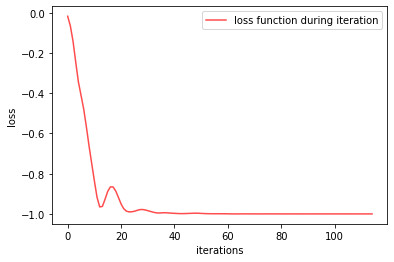

In [37]:
# Print the loss function during iteration
plt.figure(1)
ITR_list = []
for i in range(ITR):
    ITR_list.append(i)
func = plt.plot(ITR_list, loss_list, alpha=0.7, marker='', linestyle='-', color='r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(labels=["loss function during iteration"], loc='best')
plt.show()

**As the "-Fidelity" becomes "-1", this circuit learns to prepare the target state "$|01\rangle\otimes|+\rangle$".**